In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import callbacks

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "mfcc_data_20s.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfccs"])
    y = np.array(data["labels"])
    genres = data["genres"]

    print("Data succesfully loaded!")

    return  X, y, genres

In [2]:
# load data
X, y, genres = load_data(DATA_PATH)

Data succesfully loaded!


In [71]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 17240)             0         
                                                                 
 dense_48 (Dense)            (None, 512)               8827392   
                                                                 
 dense_49 (Dense)            (None, 256)               131328    
                                                                 
 dense_50 (Dense)            (None, 64)                16448     
                                                                 
 dense_51 (Dense)            (None, 10)                650       
                                                                 
Total params: 8,975,818
Trainable params: 8,975,818
Non-trainable params: 0
_________________________________________________________________


In [76]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=25)

Epoch 1/25
13/13 [==============================] - 2s 103ms/step - loss: 33.6232 - accuracy: 0.1990 - val_loss: 17.4283 - val_accuracy: 0.2950
Epoch 2/25
13/13 [==============================] - 1s 93ms/step - loss: 10.6778 - accuracy: 0.3980 - val_loss: 9.4204 - val_accuracy: 0.3900
Epoch 3/25
13/13 [==============================] - 1s 95ms/step - loss: 5.4714 - accuracy: 0.5332 - val_loss: 7.9106 - val_accuracy: 0.3950
Epoch 4/25
13/13 [==============================] - 1s 94ms/step - loss: 3.1223 - accuracy: 0.6283 - val_loss: 6.8338 - val_accuracy: 0.4100
Epoch 5/25
13/13 [==============================] - 1s 95ms/step - loss: 1.7024 - accuracy: 0.7672 - val_loss: 5.7710 - val_accuracy: 0.4550
Epoch 6/25
13/13 [==============================] - 1s 95ms/step - loss: 0.9806 - accuracy: 0.8260 - val_loss: 5.8692 - val_accuracy: 0.4350
Epoch 7/25
13/13 [==============================] - 1s 97ms/step - loss: 0.4980 - accuracy: 0.8748 - val_loss: 4.6987 - val_accuracy: 0.4600
Epoch 8/2

Evaluate on test data
4/4 [==============================] - 0s 10ms/step - loss: 5.4493 - accuracy: 0.5250
test loss, test acc: [5.449275016784668, 0.5249999761581421]


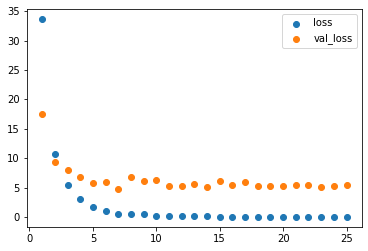

In [77]:
plt.scatter([i+1 for i in range(25)],history.history['loss'])
plt.scatter([i+1 for i in range(25)],history.history['val_loss'])
plt.legend(['loss','val_loss'])
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

In [78]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for tests")
predictions = model.predict(X_test)

Generate predictions for tests
7/7 [==============================] - 0s 8ms/step


In [79]:
correct = [0 for genre in genres]
pred_data = [[0 for g in genres] for genre in genres]
pred_count = [[0 for g in genres] for genre in genres]
genre_count = [0 for genre in genres]
for i in range(predictions.shape[0]):
    max_confidence = max(predictions[i])
    pred = np.argmax(predictions[i])
    actual = y_test[i]
    
    genre_count[actual] += 1
    pred_count[actual][pred] += 1
    pred_data[actual] += predictions[i]
    
    if pred == actual:
        correct[actual] += 1
#     print('Prediction:', genres[pred], '\tActual:', genres[actual], '\nConfidence:', max(predictions[i]),'\n')

pred_data = np.asarray(pred_data) / genre_count

In [80]:
curr_genre = 0
for c,g in zip(correct,genre_count):
    print(genres[curr_genre], ': ', c / g * 100,'% correct')
    curr_genre += 1

print('\nTotal: ', sum(correct) / sum(genre_count) * 100, '% correct')

blues :  33.33333333333333 % correct
classical :  96.0 % correct
country :  37.5 % correct
disco :  36.36363636363637 % correct
hiphop :  37.5 % correct
jazz :  65.0 % correct
metal :  94.44444444444444 % correct
pop :  72.22222222222221 % correct
reggae :  36.0 % correct
rock :  10.526315789473683 % correct

Total:  52.5 % correct


In [81]:
# Bar graphs for genre-specific confidence levels
# counter = 0
# for dist in pred_data:
#     plt.figure(counter, figsize=(8, 6))
#     plt.bar(x=genres, height=dist, color='#0504aa', alpha=0.7, width=0.8)
#     plt.grid(axis='y', alpha=0.75)
#     plt.xlabel('Genres')
#     plt.ylabel('Confidence')
#     plt.title(genres[counter])
#     counter += 1

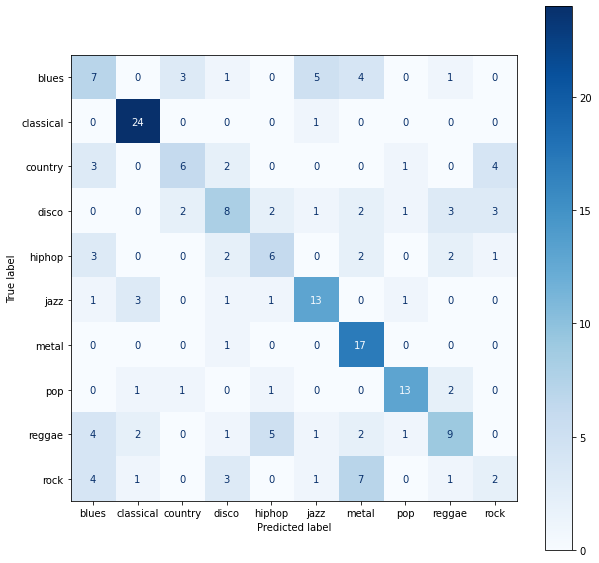

In [82]:
# Confusion matrix
confusion_matrix = np.asarray(pred_count)
# print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = genres)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax = ax, cmap='Blues')
plt.show()